# <span style="background-color:white;color:red;"> ⌛⌛ EN PROGRESO⌛⌛</span>

## Bloque I
Descomprimir el csv en formato gz

In [3]:
"""  
Importación de ficheros de AIRBNB. Preprocesado y cargado a la base de datos 

Obtenemos los datos desde https://insideairbnb.com/get-the-data/

Podríamos hacer scraping, obtener la fecha de la última actualización de Madrid y generar el enlace para descargarlo, pero no es necesario por que se actualiza cada mucho tiempo y no es necesario tener la última versión. Podemos cambiar la info procesable en la carpeta data manualmente.

"""
import os
import pandas as pd
import numpy as np
import datetime
from config_bd import *
import requests
import sys
import gzip
import shutil

DATA_DIR = os.path.join('data')
# DATA_DIR = os.path.join(os.path.dirname(__file__), 'data')
TEMP_DIR = os.path.join(DATA_DIR, 'TEMP')


""" Comprobamos que existe el directorio de datos """

if not os.path.exists(DATA_DIR):
    print(f"El directorio {DATA_DIR} no existe. No es posible continuar...")
    sys.exit()

""" Descomprimimos el archivo de calendario """

if not os.path.exists(TEMP_DIR):
    os.makedirs(TEMP_DIR)


gz_file_path = os.path.join(DATA_DIR, 'listings.csv.gz')
output_file_path = os.path.join(TEMP_DIR, os.path.splitext(os.path.basename(gz_file_path))[0])

if os.path.exists(gz_file_path):
    try:
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(output_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Archivo {gz_file_path} descomprimido como {output_file_path}")
    except Exception as e:
        print(f"Error al descomprimir el archivo {gz_file_path}: {e}")
        sys.exit()
else:
    print(f"El archivo {gz_file_path} no existe. No es posible continuar...")
    sys.exit()


Archivo data\listings.csv.gz descomprimido como data\TEMP\listings.csv


## Bloque II
Carga del csv de detalle completo en pandas. Cambios de tipos e imputación

Estos son lo pasos seguidos:

<ul>
<li>Eliminamos campos innecesarios</li>
<li>Eliminamos las propiedades que no se encuentran dentro del perímetro de interés (habitaciones, compartidas, albergues...)</li>
<li></li>
<li></li>
<li></li>
<li></li>
<li></li>
</ul>

In [4]:
df = pd.read_csv(output_file_path, low_memory=False)

Eliminamos campos innecesarios

In [5]:
df = df.drop(columns=['scrape_id','last_scraped','source','neighborhood_overview','host_id','host_url','host_name','host_since','host_location','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','bathrooms_text','beds','amenities','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','availability_eoy','number_of_reviews_ly','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_about','host_neighbourhood','calendar_updated','availability_30','availability_60','availability_90','availability_365','picture_url'])

Eliminamos las habitaciones, casas compartidas, hoteles, picaderos, etc, solo queremos viviendas completas

In [6]:
# df['property_type'].value_counts()
# df['room_type'].value_counts()
df = df[df['room_type']== 'Entire home/apt'].copy()
df['room_type'].value_counts()

room_type
Entire home/apt    16805
Name: count, dtype: int64

conversión de tipos

In [7]:
df['accommodates'] = df['accommodates'].astype(int)
df['bathrooms'] = df['bathrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['bedrooms'] = df['bedrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['minimum_nights'] = df['minimum_nights'].astype(int)
df['maximum_nights'] = df['maximum_nights'].astype(int)
df['estimated_occupancy_l365d'] = df['estimated_occupancy_l365d'].astype(int)

imputamos una habitación y un baño cuando esta información no está rellena, asumiendo que habiendo retirado las propiedades compartidas, podemos interpretar que los estudios, lofts, etc todos van a tener al menos una habitación y baño o equivalente. (Sofá cama, etc).

*También se podría imputar las habitaciones dividiendo los "acommodates" entre dos pero creo que este método es más conservador.*

In [8]:
# df[(df['bathrooms'] == 0)& (df['bedrooms']==0)]
df['bathrooms'] = df['bathrooms'].replace(0,1)
df['bedrooms'] = df['bedrooms'].replace(0,1)

In [9]:
df = df.rename(columns={'id':'property_id'})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16805 entries, 1 to 25285
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  price 

## Bloque III
Importamos a la base de datos. 
**Requiere haber creado la tabla** <code>01_CREATE TABLE bnb_property.sql</code>

In [11]:
from config_bd import get_connection

In [12]:
df.to_csv(os.path.join(TEMP_DIR,'transform_listings.csv'), index=False)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16805 entries, 1 to 25285
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  price 

# ⌛VOY POR AQUÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍ

In [14]:
# from tqdm import tqdm
# # from time import sleep

# with get_connection() as conn:
#     cursor = conn.cursor()
#     cursor.fast_executemany = True 

#     CHUNKSIZE = 500
#     for chunk in tqdm(
#         pd.read_csv(os.path.join(TEMP_DIR, 'transform_calendar.csv'), chunksize=CHUNKSIZE),
#         unit_scale=CHUNKSIZE, unit=" filas"
#     ):

#         insert_sql = """
#         INSERT INTO dbo.bnb_calendar
#             (property_id, [date], available, price,
#             minimum_nights, maximum_nights)
#         VALUES (?,?,?,?,?,?)
#         """
#         cursor.executemany(insert_sql, chunk.values.tolist())
#         conn.commit()        




~~Elimino el fichero para no dejar duplicado el csv~~
<span style="color:orange">En este notebook no hay que eliminar el transformado ya que lo vamos a emplear desde el notebook de calendars, evitando importar a la base de datos la información que no nos interesa respecto a las viviendas que hemos eliminado.</span>

In [15]:
# os.remove(os.path.join(TEMP_DIR,'transform_listings.csv'))

In [16]:
df = pd.read_csv(os.path.join(TEMP_DIR,'transform_listings.csv'))

In [21]:
# df['id'].max()
# df['neighbourhood_cleansed'].value_counts()
df['neighbourhood_group_cleansed'].value_counts()

neighbourhood_group_cleansed
Centro                   7892
Salamanca                1325
Tetuán                   1124
Chamberí                 1118
Arganzuela                861
Retiro                    615
Chamartín                 614
Carabanchel               439
Ciudad Lineal             434
Puente de Vallecas        410
Moncloa - Aravaca         371
Latina                    301
Hortaleza                 294
Usera                     276
San Blas - Canillejas     265
Fuencarral - El Pardo     175
Villaverde                 97
Barajas                    70
Villa de Vallecas          60
Moratalaz                  40
Vicálvaro                  24
Name: count, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16805 entries, 0 to 16804
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  p

In [25]:
df.sort_values(by="estimated_revenue_l365d",ascending=False).head(10)

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d
11667,1087700981397177073,https://www.airbnb.com/rooms/1087700981397177073,Stunning duplex | Terrace & BBQ | Free Parking,Discover our duplex in the North Zone of Madri...,Valdeacederas,Tetuán,40.467680,-3.708650,Entire rental unit,Entire home/apt,6,2,2,23124.0,3,365,114,2636136.0
1701,18816591,https://www.airbnb.com/rooms/18816591,PUERTA DEL ANGEL,"Located next to Paseo De Extremadura, a few me...",Puerta del Angel,Latina,40.409160,-3.732560,Entire rental unit,Entire home/apt,4,1,1,19276.0,3,365,102,1966152.0
6248,577960547451462595,https://www.airbnb.com/rooms/577960547451462595,Luxury La Latina,"Steps away from the royal palace, the Cebada m...",Palacio,Centro,40.409010,-3.713490,Entire rental unit,Entire home/apt,4,1,2,2251.0,1,730,255,574005.0
9362,918580151552814707,https://www.airbnb.com/rooms/918580151552814707,Cozy apartment with balconies in Chueca,Welcome to this beautiful Airbnb apartment in ...,Justicia,Centro,40.423673,-3.699559,Entire rental unit,Entire home/apt,2,1,1,6517.0,3,365,84,547428.0
5431,50995991,https://www.airbnb.com/rooms/50995991,Cozy and central studio - Puerta del Sol,"Cozy studio, renovated, with a careful design ...",Sol,Centro,40.419110,-3.705490,Entire rental unit,Entire home/apt,2,1,1,2069.0,1,1125,210,434490.0
1509,17932739,https://www.airbnb.com/rooms/17932739,Bright & Spacious 2BD 2BTH - Las Letras,Spacious and bright apartment located in the B...,Cortes,Centro,40.412890,-3.696620,Entire rental unit,Entire home/apt,6,2,2,1302.0,1,1125,255,332010.0
6003,54408298,https://www.airbnb.com/rooms/54408298,Modern & Bright - 2Bedrooms 1.5Baths -Plaza Es...,Bright apartment located in the heart of Madri...,Argüelles,Moncloa - Aravaca,40.426060,-3.715450,Entire rental unit,Entire home/apt,5,1,2,3420.0,1,1125,96,328320.0
14249,1236338692469671335,https://www.airbnb.com/rooms/1236338692469671335,Luxury Jerónimos,This brand new unique apartment is located in ...,Jerónimos,Retiro,40.418493,-3.691579,Entire rental unit,Entire home/apt,6,3,3,1174.0,20,365,240,281760.0
4965,46653997,https://www.airbnb.com/rooms/46653997,LUXURY PENTHOUSE. TERRACE + SWIMMING POOL,Penthouse decorated in detail with high qualit...,Hellín,San Blas - Canillejas,40.433160,-3.619620,Entire condo,Entire home/apt,4,1,1,1000.0,2,1000,255,255000.0
4471,42595353,https://www.airbnb.com/rooms/42595353,Luxury Penthouse W/Terrace - 5BD 5BTH - Gran vía,Luxury penthouse in historic building located ...,Justicia,Centro,40.420440,-3.697180,Entire rental unit,Entire home/apt,10,5,5,1545.0,1,1125,150,231750.0


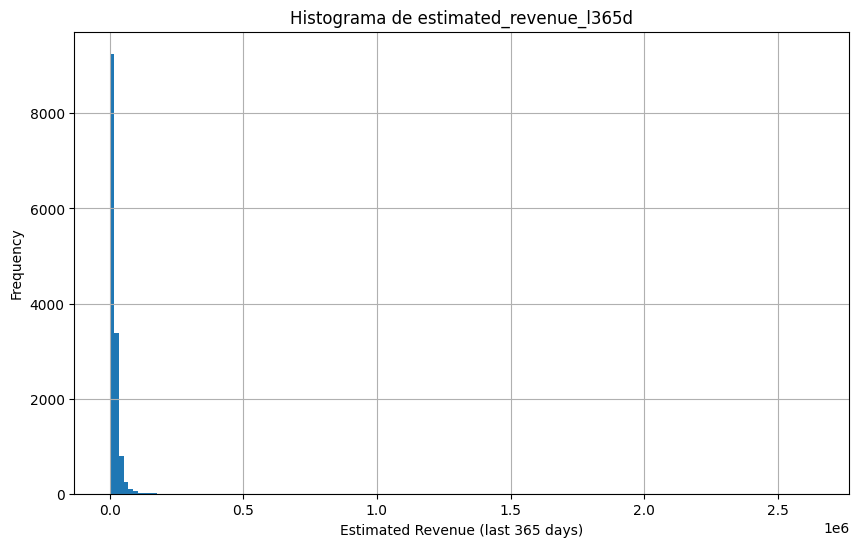

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df['estimated_revenue_l365d'].dropna().hist(bins=150)
plt.xlabel('Estimated Revenue (last 365 days)')
plt.ylabel('Frequency')
plt.title('Histograma de estimated_revenue_l365d')
plt.show()